## Librairies
in this section we import all libraries we use in the next sections

In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import struct
import pandas as pd
import scipy.stats as st
from array import array as pyarray
import pickle
import itertools
import math
from sklearn.metrics import confusion_matrix as cmx
import tarfile
from urllib.request import urlretrieve
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.multioutput import MultiOutputClassifier

## All function
in this section, we define all our function (like a utils file)

In [2]:
def load_cifar10(filename):
    """This function is to load our data
    params: filename  is the path of our dataset
    type:  string 
    return: all_images, all_labels 
    type: np.arrays,  np.arrays
    """
    batches = ['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5', 'test_batch']
    
    tar = tarfile.open(filename, "r:gz")
    
    tar_contents = [(file.name.split('/')[-1], file) for file in tar.getmembers()]
    tar_contents = sorted(filter(lambda x: x[0] in batches, tar_contents), key=lambda x: x[0])
    all_images = {}
    all_labels = {}

    for member in tar_contents:
        f = tar.extractfile(member[1])
        if f is not None:
            content = pickle.load(f, encoding='bytes')
            images, labels = convert_image_from_pack(content)
            all_images[member[0]] = images
            all_labels[member[0]] = labels
    tar.close()
    return all_images, all_labels

def convert_image_from_pack(raw_data):
    images = []
    labels = []
    
    def get_image_format(data):
        return np.array([[data[i], data[i + 1024], data[i + 2048]] for i in range(1024)])

    for i in range(len(raw_data[b'data'])):
        image_format = get_image_format(raw_data[b'data'][i])
        label = raw_data[b'labels'][i]
        #filepath = path + "/" + str(label) + "/" + raw_data['filenames'][i]
        #saveImage(image_format, "RGB", (32, 32), filepath)
        #logfile.write(filepath + "\t" + str(label) + "\n")
        images += [image_format]
        labels += [label]
        
    return np.array(images), labels



def display(images, label, index, grayScaled=False, shape1=32, shape2=32):
    if grayScaled : 
        plt.imshow(images[index].reshape(shape1, shape2, 1), cmap='gray')
    else:
        plt.imshow(images[index].reshape(shape1, shape2, 3))
    plt.title(labels_dict[label[index]])
    plt.show()
    
def balanced_subsample(x,y,subsample_size=1.0):

    class_xs = []
    min_elems = None

    for yi in np.unique(y):
        elems = x[(y == yi)]
        class_xs.append((yi, elems))
        if min_elems == None or elems.shape[0] < min_elems:
            min_elems = elems.shape[0]

    use_elems = min_elems
    if subsample_size < 1:
        use_elems = int(min_elems*subsample_size)

    xs = []
    ys = []

    for ci,this_xs in class_xs:
        if len(this_xs) > use_elems:
            np.random.shuffle(this_xs)

        x_ = this_xs[:use_elems]
        y_ = np.empty(use_elems)
        y_.fill(ci)

        xs.append(x_)
        ys.append(y_)

    xs = np.concatenate(xs)
    ys = np.concatenate(ys)

    return xs,ys

def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=90)
    plt.yticks(tick_marks, names)
    fmt = '.2f' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j],fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
            
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Dowload CIFAR10 dataset

In [3]:
dataset_url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
dataset_name = 'cifar-10-python.tar.gz'
dataset_path = os.path.join(os.getcwd(), 'dataset')
cifar_path =  os.path.join(dataset_path, dataset_name)
urlretrieve(dataset_url, os.path.join(dataset_path, dataset_name))
print("dataset cifar is in {}".format(dataset_path))

dataset cifar is in /home/adlan/Music/university/paris8/nedra/dataset


## load DATA 
#### Description : 
- There is 6 batch of images 
- we use 5 batch for training and 1 batch for testing 

In [75]:
images, labels = load_cifar10(cifar_path)

In [76]:
print("count test images is {}".format(len(images['test_batch'])))
# count=0
# count= [len(images['data_batch_{}'.format(i)]) for i in range(1,6)]
# print(count)
count_train_img = len(images['data_batch_1'])+ len(images['data_batch_2']) + len(images['data_batch_3'])+ len(images['data_batch_4']) +len(images['data_batch_5'])  
print("count training images is {}".format(count_train_img))

count test images is 10000
count training images is 50000


In [77]:
X_train = np.concatenate([images['data_batch_1'], images['data_batch_1'], images['data_batch_3'],images['data_batch_4'], images['data_batch_5']])
X_test = images['test_batch']

y_train = np.concatenate([labels['data_batch_1'], labels['data_batch_1'], labels['data_batch_3'],labels['data_batch_4'], labels['data_batch_5']])
y_test = labels['test_batch']

labels_name = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
labels_dict = {key: value for key, value in enumerate(labels_name)}

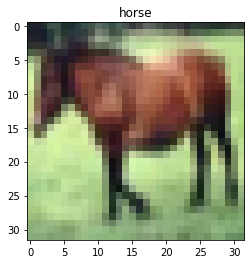

In [79]:
display(X_train, y_train, 7)

# Processing data
we convert our images from colored to grayscale

In [81]:
X_train_gray = np.array([cv2.cvtColor(image.reshape(32, 32, 3), cv2.COLOR_BGR2GRAY) for image in X_train])
X_test_gray = np.array([cv2.cvtColor(image.reshape(32, 32, 3), cv2.COLOR_BGR2GRAY) for image in X_test])

### display result

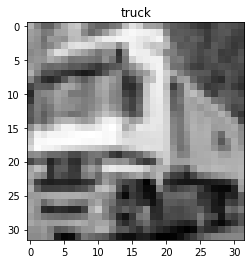

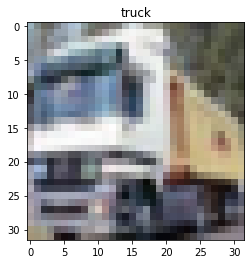

In [82]:
display(X_train_gray, y_train, index= 1, grayScaled=True)
display(X_train, y_train, index= 1, grayScaled=False)

## data normalization 
- in this section we are going to normalize data (values between 0 and 1) by dividing all values by 255 

In [83]:
X_train_gray_normalized = X_train_gray/255
X_test_gray_normalized = X_test_gray/255

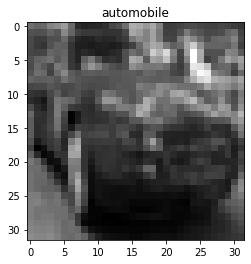

[[0.69411765 0.52941176 0.39607843 ... 0.34117647 0.32941176 0.30196078]
 [0.62745098 0.59607843 0.48235294 ... 0.36078431 0.29019608 0.27058824]
 [0.61176471 0.57254902 0.44705882 ... 0.29803922 0.25490196 0.25490196]
 ...
 [0.65882353 0.61176471 0.63529412 ... 0.14117647 0.21568627 0.34117647]
 [0.57647059 0.57254902 0.60784314 ... 0.37254902 0.45882353 0.49019608]
 [0.55294118 0.55294118 0.58823529 ... 0.53333333 0.5372549  0.5372549 ]]


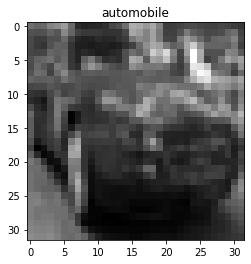

[[177 135 101 ...  87  84  77]
 [160 152 123 ...  92  74  69]
 [156 146 114 ...  76  65  65]
 ...
 [168 156 162 ...  36  55  87]
 [147 146 155 ...  95 117 125]
 [141 141 150 ... 136 137 137]]


In [84]:
display(X_train_gray_normalized, y_train, index= 5, grayScaled=True)
print(X_train_gray_normalized[1])
display(X_train_gray, y_train, index= 5, grayScaled=True)
print(X_train_gray[1])

## distribusion of our data
- we check  that our data is imbalanced
- we balance our data 

In [85]:
count = []
(unique, counts) = np.unique(np.concatenate((y_train, y_test), axis=0), return_counts=True)
for i, v in zip(unique, counts):
    count.append((labels_dict[i], v))
    

statistic = pd.DataFrame(count, columns=['class', 'number_of_images'])
statistic

,class,number_of_images
0,airplane,6021
1,automobile,5967
2,bird,6022
3,cat,6021
4,deer,5989
5,dog,5949
6,frog,6022
7,horse,5975
8,ship,6038
9,truck,5996


Text(0.5, 0, 'class')

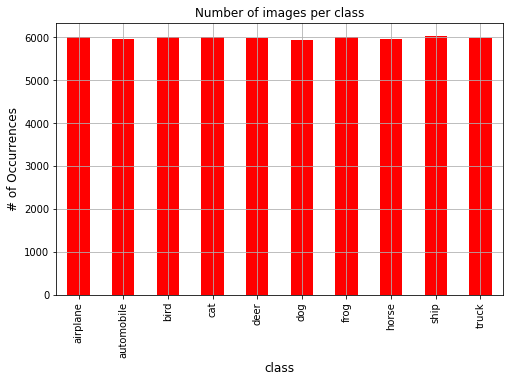

In [13]:
statistic.plot(x='class', y='number_of_images',color='red', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of images per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('class', fontsize=12)

#### balancing our data

In [86]:
X_train_gray_normalized ,y_train = balanced_subsample(X_train_gray_normalized,y_train,subsample_size=1.0)
X_test_gray_normalized ,y_test = balanced_subsample(X_test_gray_normalized,y_test,subsample_size=1.0)
X_test_gray_normalized.shape , X_train_gray_normalized.shape

((10000, 32, 32), (49490, 32, 32))

In [87]:
count = []
(unique, counts) = np.unique(np.concatenate((y_train, y_test), axis=0), return_counts=True)
for i, v in zip(unique, counts):
    count.append((labels_dict[i], v))
    

statistic = pd.DataFrame(count, columns=['class', 'number_of_images'])
statistic

,class,number_of_images
0,airplane,5949
1,automobile,5949
2,bird,5949
3,cat,5949
4,deer,5949
5,dog,5949
6,frog,5949
7,horse,5949
8,ship,5949
9,truck,5949


## Label Encoding 

In [88]:
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoder.fit(y_train.reshape(-1, 1))
y_train[:] , len(y_train)

(array([0., 0., 0., ..., 9., 9., 9.]), 49490)

In [89]:
type(y_test), type(y_train)

(numpy.ndarray, numpy.ndarray)

In [150]:
pd.DataFrame(y_train)

,0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
49485,9.0
49486,9.0
49487,9.0
49488,9.0


In [90]:
y_train_encoded = one_hot_encoder.transform(y_train.reshape(-1, 1))
y_test_encoded = one_hot_encoder.transform(np.array(y_test).reshape(-1, 1))

In [91]:
len(X_train_gray_normalized), len(y_train_encoded), len(X_test_gray_normalized), len(y_test_encoded) 

(49490, 49490, 10000, 10000)

In [215]:
#X_train_gray_normalized_new = X_train_gray_normalized.reshape(X_train_gray_normalized.shape[0], X_train_gray_normalized.shape[1], X_train_gray_normalized.shape[2], 1)
#X_test_gray_normalized_new = X_test_gray_normalized.reshape(X_test_gray_normalized.shape[0], X_test_gray_normalized.shape[1], X_test_gray_normalized.shape[2], 1)

#"shape after normilze gray image :",X_train_gray_normalized_new.shape

('shape after normilze gray image :', (50000, 32, 32, 1))

## Flatten (the last layer of CNN, to represent our image as a vector ==> features)

In [92]:
#1st way of flatten by using flatten method of numpy on the matrix
X_train_gray_features = np.array([np.matrix(image).flatten() for image in X_train_gray_normalized])
X_test_gray_features = np.array([np.matrix(image).flatten() for image in X_test_gray_normalized])
X_train_gray_normalized.shape, X_train_gray_features.shape 

((49490, 32, 32), (49490, 1, 1024))

In [93]:
#2nd way of flatten by reshaping the matrix
X_train_gray_features = np.array([np.reshape(image, (32*32)) for image in X_train_gray_normalized])
X_test_gray_features = np.array([np.reshape(image, (32*32)) for image in X_test_gray_normalized])
X_train_gray_normalized.shape, X_train_gray_features.shape 

((49490, 32, 32), (49490, 1024))

In [94]:
training_X = pd.DataFrame(data=X_train_gray_features)
training_y= pd.DataFrame(data=y_train_encoded)

testing_X = pd.DataFrame(X_test_gray_features)
testing_y = pd.DataFrame(data=y_test_encoded)
X_test_gray_features.shape , testing_X.shape , type(X_test_gray_features)

((10000, 1024), (10000, 1024), numpy.ndarray)

 ### Training data features

In [95]:
training_X

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,1.000000,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,...,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,1.000000
1,0.545098,0.541176,0.545098,0.552941,0.568627,0.580392,0.588235,0.588235,0.576471,0.560784,...,0.847059,0.819608,0.831373,0.874510,0.921569,0.949020,0.956863,0.937255,0.886275,0.831373
2,0.635294,0.584314,0.615686,0.678431,0.584314,0.525490,0.533333,0.556863,0.494118,0.494118,...,0.400000,0.403922,0.415686,0.474510,0.447059,0.450980,0.454902,0.521569,0.560784,0.568627
3,0.219608,0.227451,0.250980,0.278431,0.247059,0.258824,0.270588,0.270588,0.266667,0.258824,...,0.211765,0.203922,0.192157,0.215686,0.203922,0.184314,0.176471,0.168627,0.172549,0.168627
4,0.576471,0.600000,0.615686,0.619608,0.619608,0.619608,0.619608,0.627451,0.631373,0.643137,...,0.372549,0.376471,0.380392,0.368627,0.368627,0.396078,0.368627,0.337255,0.317647,0.329412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49485,0.541176,0.533333,0.533333,0.533333,0.537255,0.533333,0.517647,0.521569,0.541176,0.537255,...,0.435294,0.439216,0.486275,0.505882,0.521569,0.541176,0.552941,0.556863,0.521569,0.474510
49486,0.717647,0.729412,0.749020,0.760784,0.776471,0.784314,0.796078,0.800000,0.811765,0.815686,...,0.603922,0.603922,0.603922,0.623529,0.654902,0.654902,0.647059,0.658824,0.674510,0.686275
49487,0.376471,0.372549,0.372549,0.372549,0.372549,0.376471,0.380392,0.384314,0.392157,0.396078,...,0.321569,0.321569,0.325490,0.317647,0.321569,0.329412,0.337255,0.337255,0.337255,0.333333
49488,0.733333,0.725490,0.733333,0.749020,0.752941,0.690196,0.600000,0.580392,0.596078,0.631373,...,0.117647,0.133333,0.176471,0.227451,0.282353,0.333333,0.360784,0.372549,0.376471,0.380392


### Training data labels

In [96]:
training_y

,0,1,2,3,4,5,6,7,8,9
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
49485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
49486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
49487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
49488,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Machine LEARNING

In [97]:
from sklearn.model_selection import train_test_split
X_train_, X_test_, y_train_, y_test_ = train_test_split(training_X, training_y, test_size=0.3, shuffle=True, random_state=42)

In [98]:
y_train_

,0,1,2,3,4,5,6,7,8,9
23001,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
26257,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
11786,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7154,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26517,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
11284,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44732,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
38158,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
860,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [99]:
X_train_.shape, y_train_.shape

((34643, 1024), (34643, 10))

# ################# RandomForestClassifier \################# 

# Multi-label 

#### variation of max feature PARAMS 

In [ ]:
training_scoring_max_features=[]
testing_scoring_max_features=[]
#features=[]
for max_feature in np.arange(1,X_train_.shape[1],200):
    max_feature = 500
    model_randomForest = RandomForestClassifier(min_samples_split = 5, class_weight='balanced',n_estimators=100,
                                                max_features=max_feature, criterion='gini')

    #X_train.shape , y_train.shape
    rm_clf = MultiOutputClassifier(model_randomForest, n_jobs=-1)
    rm_clf.fit(X_train_,y_train_)
    score_testing = rm_clf.score(X_test_,y_test_)
    score_training = rm_clf.score(X_train_, y_train_)
    training_scoring.append(score_training)
    testing_scoring.append(score_testing)
    features.append(max_feature)
    print("finished")

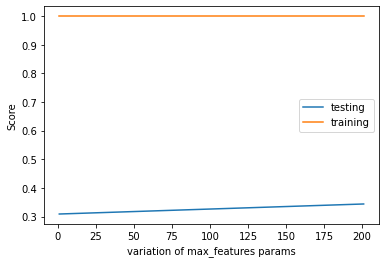

In [108]:
plt.plot(features, testing_scoring, label='testing')
plt.plot(features, training_scoring, label='training')
plt.xlabel("variation of max_features params")
plt.ylabel("Score")
plt.legend()

In [110]:
model_randomForest = RandomForestClassifier(min_samples_split = 5, class_weight='balanced',n_estimators=100,
                                            max_features=1000, criterion='gini')

#X_train.shape , y_train.shape
rm_clf = MultiOutputClassifier(model_randomForest, n_jobs=-1)
rm_clf.fit(X_train_,y_train_)
score_testing = rm_clf.score(X_test_,y_test_)
score_training = rm_clf.score(X_train_, y_train_)
score_training, score_testing

(0.9993938169327137, 0.3312453694349027)

In [ ]:
"training scores for variation max_features:\n",training_scoring

In [ ]:
"testing scores for variation max_features:\n",testing_scoring

##### variation of MAX_DEPTH PARAMS

In [114]:
training_scoring_max_depth=[]
testing_scoring_max_depth=[]
deep_values=[]
for depth in range(2,20,4):
    model_randomForest = RandomForestClassifier(min_samples_split = 5, class_weight='balanced',n_estimators=100,
                              max_features='auto',criterion='gini', max_depth=depth)

    #X_train.shape , y_train.shape
    rm_clf = MultiOutputClassifier(model_randomForest, n_jobs=-1)
    rm_clf.fit(X_train_,y_train_)
    score_testing = rm_clf.score(X_test_,y_test_)
    score_training = rm_clf.score(X_train_, y_train_)
    training_scoring_max_depth.append(score_training)
    testing_scoring_max_depth.append(score_testing)
    deep_values.append(depth)
    print("depth: ",depth)

'finished'

In [103]:
"training scores for variation max_depth:\n",training_scoring

[0.0028577201743497965,
 0.061022428773489595,
 0.42375082989348495,
 0.6809745114453136,
 0.7910111710879543]

In [ ]:
"testing scores for variation max_depth:\n",testing_scoring

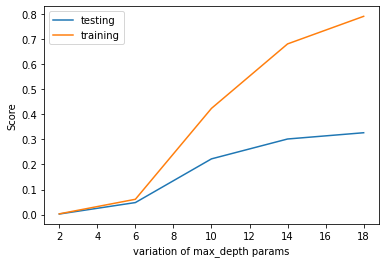

In [104]:
plt.plot(deep_values, testing_scoring, label='testing')
plt.plot(deep_values, training_scoring, label='training')
plt.xlabel("variation of max_depth params")
plt.ylabel("Score")
plt.legend()

In [115]:
model_randomForest = RandomForestClassifier(min_samples_split = 5, class_weight='balanced',n_estimators=100,
                              max_features='auto',criterion='gini', max_depth=20)
cv_result = cross_val_score(model_randomForest, X_train_, y_train_, cv=5)
#X_train.shape , y_train.shape
model_randomForest.fit(X_train_,y_train_)
score_testing = model_randomForest.score(X_test_,y_test_)
score_training = model_randomForest.score(X_train_, y_train_)
score_training, score_testing, cv_result

(0.7721040325606905,
 0.22704923553579848,
 array([0.19974022, 0.19021504, 0.19526627, 0.1823037 , 0.19515012]))

### report

In [116]:
from sklearn.metrics import confusion_matrix, classification_report
print ("rapport: \n",classification_report(training_y, model_randomForest.predict(training_X)))

rapport: 
               precision    recall  f1-score   support

           0       0.98      0.63      0.77      4949
           1       1.00      0.67      0.81      4949
           2       1.00      0.50      0.67      4949
           3       1.00      0.59      0.74      4949
           4       1.00      0.50      0.66      4949
           5       1.00      0.58      0.74      4949
           6       1.00      0.60      0.75      4949
           7       1.00      0.63      0.77      4949
           8       0.99      0.68      0.80      4949
           9       0.99      0.70      0.82      4949

   micro avg       1.00      0.61      0.76     49490
   macro avg       1.00      0.61      0.75     49490
weighted avg       1.00      0.61      0.75     49490
 samples avg       0.61      0.61      0.61     49490



In [356]:
#df = df.drop(df[<some boolean condition>].index)
output = out_test.loc[(out_test.sum(axis=1) != 0)]
output

,0,1,2,3,4,5,6,7,8,9
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
29,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
34,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
9948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9956,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9968,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9981,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Random FOREST with uni-label 

In [170]:
training_scoring_max_depth=[]
testing_scoring_max_depth=[]
deep_values=[]
for depth in range(2,100,5):
    rm_clf = RandomForestClassifier(min_samples_split = 5, class_weight='balanced',n_estimators=100,
                              max_features='auto',criterion='gini', max_depth=depth)

    #X_train.shape , y_train.shape
    rm_clf.fit(X_train__,y_train__)
    score_testing = rm_clf.score(X_test__,y_test__)
    score_training = rm_clf.score(X_train__, y_train__)
    training_scoring_max_depth.append(score_training)
    testing_scoring_max_depth.append(score_testing)
    deep_values.append(depth)
    print("depth: ",depth)

depth:  2
depth:  7
depth:  12
depth:  17
depth:  22
depth:  27
depth:  32
depth:  37
depth:  42
depth:  47
depth:  52
depth:  57
depth:  62
depth:  67
depth:  72
depth:  77
depth:  82
depth:  87
depth:  92
depth:  97


In [166]:
"training scores for variation max_depth:\n",training_scoring

('training scores for variation max_depth:\n',
 [0.9992494876309789, 0.9992494876309789])

In [167]:
"testing scores for variation max_depth:\n",testing_scoring

('testing scores for variation max_depth:\n',
 [0.30888394961945176, 0.3439078601737725])

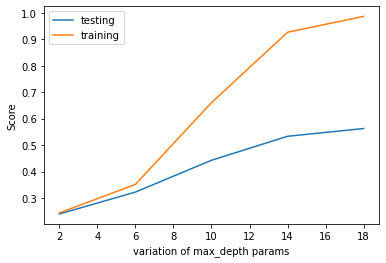

In [169]:
plt.plot(deep_values, testing_scoring_max_depth, label='testing')
plt.plot(deep_values, training_scoring_max_depth, label='training')
plt.xlabel("variation of max_depth params")
plt.ylabel("Score")
plt.legend()

#### Remarque:   learning curve commence a se stabiliser a partir de max_depth=18  (on confirme ça par la suite)

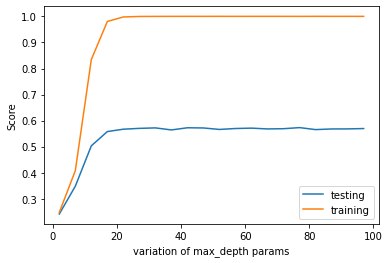

In [178]:
plt.plot(deep_values, testing_scoring_max_depth, label='testing')
plt.plot(deep_values, training_scoring_max_depth, label='training')
plt.xlabel("variation of max_depth params")
plt.ylabel("Score")
plt.legend()

##### Choosing configuration

In [151]:
model_randomForest = RandomForestClassifier(min_samples_split = 5, class_weight='balanced',n_estimators=100,
                              max_features='auto',criterion='gini', max_depth=20)
cv_result = cross_val_score(model_randomForest, X_train__, y_train__, cv=5)
#X_train.shape , y_train.shape
model_randomForest.fit(X_train__,y_train__)
score_testing = model_randomForest.score(X_test__,y_test__)
score_training = model_randomForest.score(X_train__, y_train__)
score_training, score_testing, cv_result

(0.9947464134168519,
 0.5689364854852832,
 array([0.53037956, 0.51969981, 0.53701833, 0.52886836, 0.53911663]))

In [153]:
from sklearn.metrics import confusion_matrix, classification_report
print ("rapport: \n",classification_report(y_test__, model_randomForest.predict(X_test__)))

rapport: 
               precision    recall  f1-score   support

         0.0       0.63      0.56      0.59      1514
         1.0       0.62      0.61      0.62      1511
         2.0       0.52      0.50      0.51      1470
         3.0       0.56      0.43      0.48      1469
         4.0       0.48      0.54      0.51      1479
         5.0       0.54      0.52      0.53      1462
         6.0       0.56      0.60      0.58      1536
         7.0       0.62      0.59      0.60      1465
         8.0       0.61      0.67      0.64      1462
         9.0       0.57      0.67      0.61      1479

    accuracy                           0.57     14847
   macro avg       0.57      0.57      0.57     14847
weighted avg       0.57      0.57      0.57     14847



In [154]:
out_test = pd.DataFrame(model_randomForest.predict(X_test__))
out_test

,0
0,6.0
1,2.0
2,6.0
3,0.0
4,1.0
...,...
14842,7.0
14843,9.0
14844,8.0
14845,6.0


In [352]:
"""
output.iloc[0].sum()
cpt=0
for i in range(out_test.shape[0]):
    if out_test.iloc[i].sum()==0:
        out_test = out_test.drop()
cpt, out_test.shape
"""

(614, (10000, 10))

In [86]:
#predicted = one_hot_encoder.inverse_transform(testing_y)
#predicted = one_hot_encoder.inverse_transform(out_test)
#predicted[0] , y_test[0]

## Confusion matrix 

In [159]:
out_test

,0
0,6.0
1,2.0
2,6.0
3,0.0
4,1.0
...,...
14842,7.0
14843,9.0
14844,8.0
14845,6.0


-----------------K-nearest neighbors Report---------------
Confusion matrix: 
 [[0.63283582 0.03066667 0.07102672 0.01955556 0.05467801 0.01862464
  0.03270745 0.03669065 0.13016656 0.03701595]
 [0.02164179 0.618      0.01195499 0.02577778 0.0255164  0.02722063
  0.04239855 0.03956835 0.04873535 0.12813212]
 [0.07686567 0.026      0.51898734 0.06755556 0.09295261 0.04799427
  0.08298001 0.04172662 0.03331277 0.02562642]
 [0.03656716 0.04266667 0.06329114 0.55733333 0.06743621 0.13825215
  0.08176863 0.05251799 0.02837754 0.04612756]
 [0.05298507 0.014      0.12728551 0.04355556 0.4835966  0.03939828
  0.07692308 0.06330935 0.03454658 0.01993166]
 [0.04552239 0.03666667 0.0625879  0.112      0.05528554 0.54083095
  0.05511811 0.06834532 0.0203578  0.03758542]
 [0.02686567 0.04466667 0.0625879  0.06666667 0.09599028 0.06160458
  0.55542096 0.02661871 0.01542258 0.0261959 ]
 [0.02462687 0.02933333 0.04289733 0.05422222 0.08201701 0.05730659
  0.02725621 0.62014388 0.02652684 0.05751708]
 

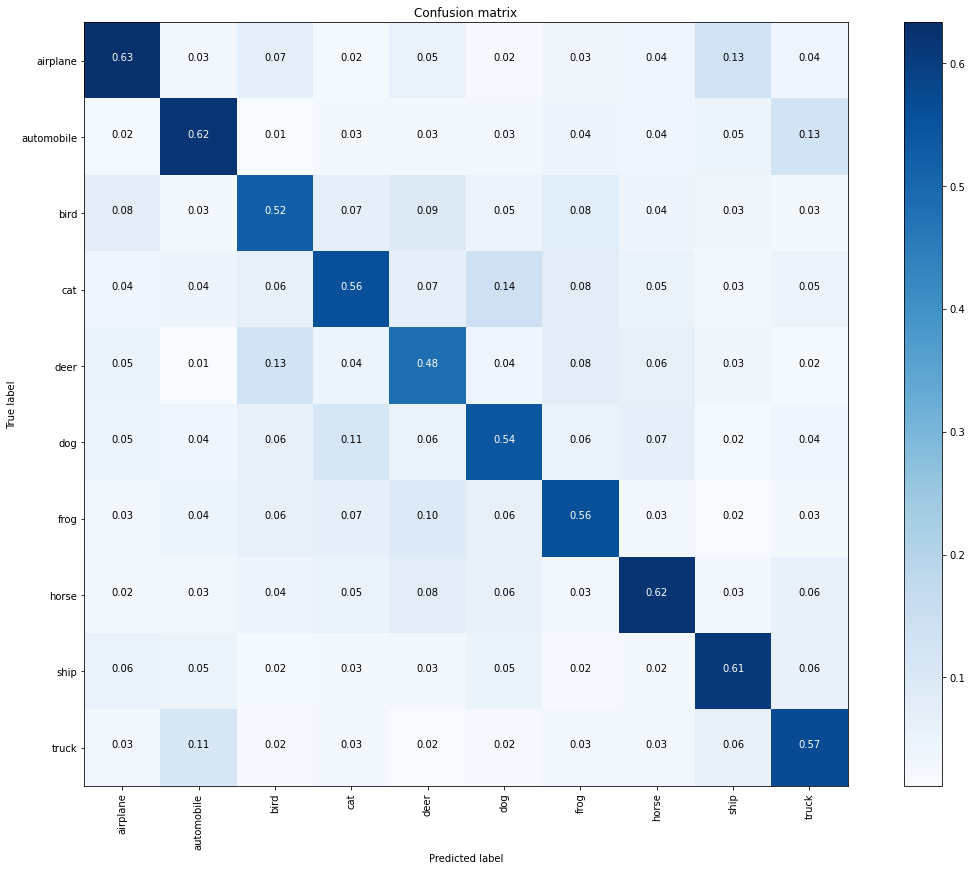

In [160]:
#rf_cm = confusion_matrix(list(pd.DataFrame(output_pred)[0]), list(pd.DataFrame(output_pred)[0]), normalize='pred')
rf_cm = confusion_matrix(y_test__, model_randomForest.predict(X_test__), normalize='pred')
print("-----------------K-nearest neighbors Report---------------")
print("Confusion matrix: \n", rf_cm)
print('Plotting confusion matrix')

#plt.figure()
plt.ion()
plt.figure(1, figsize=(16, 12))
plot_confusion_matrix(rf_cm, labels_name)
plt.show()

# ################# NAIVE BAYSE \################# 

In [136]:
from sklearn.model_selection import train_test_split
# for multi_labels
X_train_, X_test_, y_train_, y_test_ = train_test_split(training_X, training_y, test_size=0.3, shuffle=True, random_state=42)
# for uni_labels
X_train__, X_test__, y_train__, y_test__ = train_test_split(training_X, y_train, test_size=0.3, shuffle=True, random_state=42)

In [128]:
# using classifier chains
from skmultilearn.problem_transform import ClassifierChain, BinaryRelevance, LabelPowerset
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# GaussianNB on uni label data 

In [129]:
gnb_clf0 = GaussianNB()
gnb_clf0.fit(X_train__,y_train__)
pred = gnb_clf0.predict(X_test__)
accuracy_score(y_test__,pred)

0.26544082979726547

# GaussianNB on Multi-label data 

## Multi-label 

In [144]:
gnb_clf2 = BinaryRelevance(GaussianNB())
gnb_clf2.fit(X_train_,y_train_)
pred = gnb_clf2.predict(X_test_)
accuarcy = accuracy_score(y_test_,pred)
score_testing = gnb_clf1.score(X_test_,y_test_)
score_training = gnb_clf1.score(X_train_, y_train_)
score_training, score_testing, accuarcy

(0.17025084432641516, 0.17417660133360274, 0.005657708628005658)

In [145]:
gnb_clf3 = LabelPowerset(GaussianNB())
gnb_clf3.fit(X_train_,y_train_)
pred = gnb_clf3.predict(X_test_)
accuarcy = accuracy_score(y_test_,pred)
score_testing = gnb_clf1.score(X_test_,y_test_)
score_training = gnb_clf1.score(X_train_, y_train_)
score_training, score_testing, accuarcy

(0.17025084432641516, 0.17417660133360274, 0.26544082979726547)

## Uni-label 

In [138]:
gnb_clf1 = ClassifierChain(GaussianNB())
gnb_clf1.fit(X_train_,y_train_)
pred = gnb_clf1.predict(X_test_)
accuracy_score(y_test_,pred)

0.17417660133360274

In [139]:
score_testing = gnb_clf1.score(X_test_,y_test_)
score_training = gnb_clf1.score(X_train_, y_train_)

In [141]:
score_training, score_testing

(0.17025084432641516, 0.17417660133360274)

In [175]:
print ("rapport: \n",classification_report(y_test_, gnb_clf3.predict(X_test_)))

rapport: 
               precision    recall  f1-score   support

           0       0.25      0.45      0.32      1514
           1       0.35      0.10      0.15      1511
           2       0.16      0.07      0.10      1470
           3       0.22      0.06      0.10      1469
           4       0.22      0.40      0.28      1479
           5       0.27      0.23      0.25      1462
           6       0.23      0.43      0.30      1536
           7       0.42      0.11      0.18      1465
           8       0.32      0.39      0.35      1462
           9       0.37      0.40      0.39      1479

   micro avg       0.27      0.27      0.27     14847
   macro avg       0.28      0.26      0.24     14847
weighted avg       0.28      0.27      0.24     14847
 samples avg       0.27      0.27      0.27     14847



# ################# Logistic regression \################# 

# Multi-label 

In [148]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(C = 50, random_state=42)
lr_clf = MultiOutputClassifier(lr_clf, n_jobs=-1)
#clf = Pipeline([('preprocessor', preprocessor),('smt', smt),('lor',lor)])
lr_clf.fit(X_train_,y_train_)
score_testing = lr_clf.score(X_test_,y_test_)
score_training = lr_clf.score(X_train_, y_train_)
score_training, score_testing

(0.0698553820396617, 0.05698120832491412)

# uni-label

In [162]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(C = 50, random_state=42)
#lr_clf = MultiOutputClassifier(lr_clf, n_jobs=-1)
lr_clf.fit(X_train__,y_train__)
score_testing = lr_clf.score(X_test__,y_test__)
score_training = lr_clf.score(X_train__, y_train__)
score_training, score_testing

(0.34171405478740297, 0.3141375362025999)

In [171]:
print ("rapport: \n",classification_report(y_test__, lr_clf.predict(X_test__)))

rapport: 
               precision    recall  f1-score   support

         0.0       0.35      0.36      0.36      1514
         1.0       0.38      0.40      0.39      1511
         2.0       0.25      0.20      0.22      1470
         3.0       0.22      0.14      0.17      1469
         4.0       0.26      0.23      0.24      1479
         5.0       0.27      0.30      0.29      1462
         6.0       0.30      0.31      0.30      1536
         7.0       0.30      0.32      0.31      1465
         8.0       0.34      0.40      0.37      1462
         9.0       0.40      0.48      0.43      1479

    accuracy                           0.31     14847
   macro avg       0.31      0.31      0.31     14847
weighted avg       0.31      0.31      0.31     14847



-----------------K-nearest neighbors Report---------------
Confusion matrix: 
 [[0.63283582 0.03066667 0.07102672 0.01955556 0.05467801 0.01862464
  0.03270745 0.03669065 0.13016656 0.03701595]
 [0.02164179 0.618      0.01195499 0.02577778 0.0255164  0.02722063
  0.04239855 0.03956835 0.04873535 0.12813212]
 [0.07686567 0.026      0.51898734 0.06755556 0.09295261 0.04799427
  0.08298001 0.04172662 0.03331277 0.02562642]
 [0.03656716 0.04266667 0.06329114 0.55733333 0.06743621 0.13825215
  0.08176863 0.05251799 0.02837754 0.04612756]
 [0.05298507 0.014      0.12728551 0.04355556 0.4835966  0.03939828
  0.07692308 0.06330935 0.03454658 0.01993166]
 [0.04552239 0.03666667 0.0625879  0.112      0.05528554 0.54083095
  0.05511811 0.06834532 0.0203578  0.03758542]
 [0.02686567 0.04466667 0.0625879  0.06666667 0.09599028 0.06160458
  0.55542096 0.02661871 0.01542258 0.0261959 ]
 [0.02462687 0.02933333 0.04289733 0.05422222 0.08201701 0.05730659
  0.02725621 0.62014388 0.02652684 0.05751708]
 

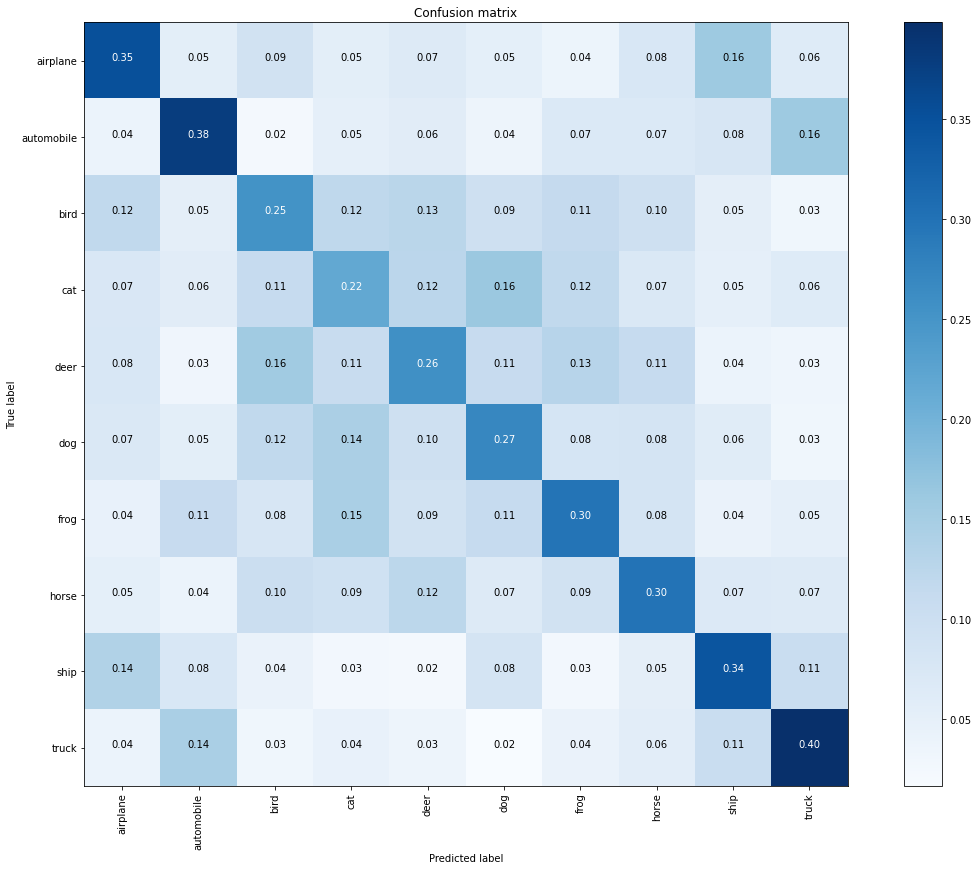

In [163]:
#rf_cm = confusion_matrix(list(pd.DataFrame(output_pred)[0]), list(pd.DataFrame(output_pred)[0]), normalize='pred')
lr_cm = confusion_matrix(y_test__, lr_clf.predict(X_test__), normalize='pred')
print("-----------------K-nearest neighbors Report---------------")
print("Confusion matrix: \n", rf_cm)
print('Plotting confusion matrix')

plt.ion()
plt.figure(1, figsize=(16, 12))
plot_confusion_matrix(lr_cm, labels_name)
plt.show()